# TP 3 CLUSTERING, ANALYSE NON-SUPERVISEE ET MLOps

## PHASE 1 : CLUSTERING BASE SUR DES REPRESENTANTS (K-MEANS)

### 1.1 Préparation des données et cas d'usage

Nous commençons par charger les données simulées de clients. L'objectif est de segmenter ces clients pour des campagnes marketing ciblées .

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configuration esthétique
sns.set(style="whitegrid")

# Tâche 1.1: Création du Dataset simulé
# Colonnes implicites : [CustomerID, Genre, Age, Annual_Income, Spending_Score]
# Nous ne gardons que les deux dernières pour la visualisation 2D comme demandé.
X_sim = np.array([
    [15, 39], [17, 35], [18, 92], [20, 95], [23, 75], 
    [78, 7],  [77, 20], [79, 3],  [40, 40], [42, 52], 
    [45, 35], [55, 60], [75, 12], [58, 58]
])

# Création d'un DataFrame pour la lisibilité
df = pd.DataFrame(X_sim, columns=['Annual_Income', 'Spending_Score'])

# Standardisation des données
# Crucial pour le K-Means car il est sensible à l'échelle (distances euclidiennes).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sim)

print("Données standardisées (5 premières lignes) :")
print(X_scaled[:5])

Données standardisées (5 premières lignes) :
[[-1.29216281 -0.19418149]
 [-1.20841151 -0.33540439]
 [-1.16653587  1.67702195]
 [-1.08278457  1.78293912]
 [-0.95715763  1.07682462]]


## 1.2 Optimisation et Évaluation (Elbow & Silhouette)

Tâche 1.2 : Méthode du Coude (Elbow Method) Nous cherchons le point d'inflexion où l'ajout d'un cluster ne réduit plus significativement l'inertie.

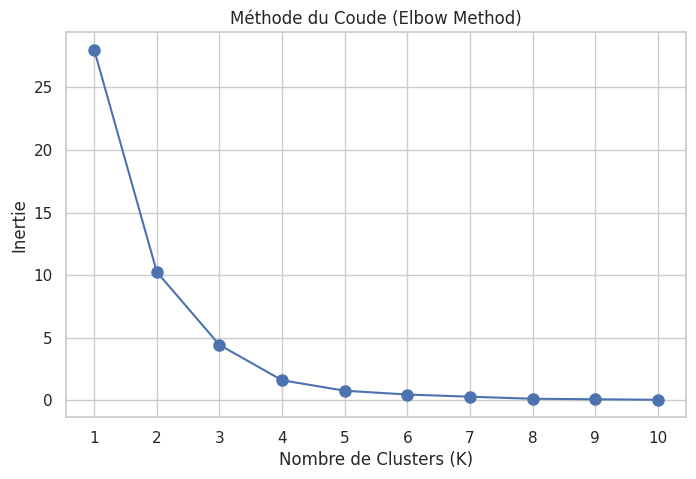

In [2]:
# Tâche 1.2: Calcul de l'inertie pour K de 1 à 10
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Visualisation
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.title("Méthode du Coude (Elbow Method)")
plt.xlabel("Nombre de Clusters (K)")
plt.ylabel("Inertie")
plt.xticks(K_range)
plt.show()

Analyse : Sur ce graphique, le "coude" se situe à $K=5$, car c'est là que la courbe présente le coude le plus prononcé. (Aussi, dans la tâche suivante, nous avons testé les différents K 3, 4 et 5 pour vérifier lequel permet un meilleur score de silhouette).

Tâche 1.3 : Coefficient de Silhouette La silhouette mesure à quel point un point est proche de son propre cluster par rapport aux clusters voisins (valeur entre -1 et 1). Une valeur proche de 1 indique un excellent clustering.


Coefficient de Silhouette pour K=5 : 0.7213


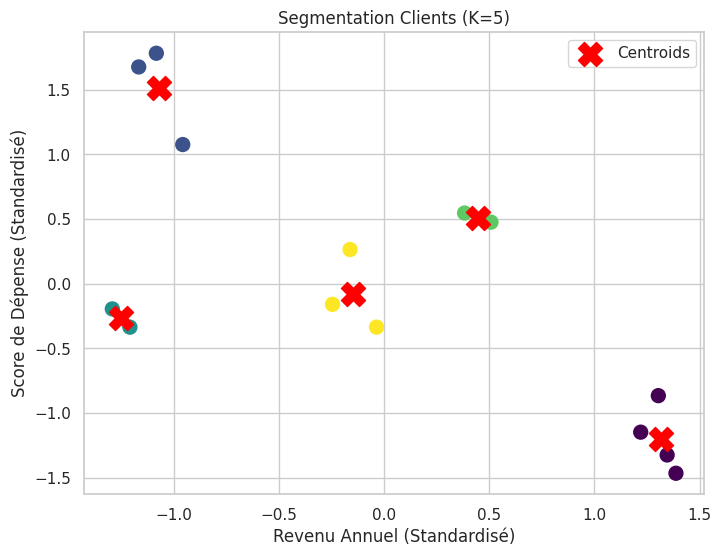

In [ ]:
# Tâche 1.3: Calcul du score pour un K optimal choisi
K_optimal = 5
kmeans_final = KMeans(n_clusters=K_optimal, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(X_scaled)

silhouette_avg = silhouette_score(X_scaled, labels)
print(f"\nCoefficient de Silhouette pour K={K_optimal} : {silhouette_avg:.4f}")

# Visualisation des clusters formés
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=100)
plt.scatter(kmeans_final.cluster_centers_[:, 0], kmeans_final.cluster_centers_[:, 1], 
            s=300, c='red', marker='X', label='Centroids')
plt.title(f"Segmentation Clients (K={K_optimal})")
plt.xlabel("Revenu Annuel (Standardisé)")
plt.ylabel("Score de Dépense (Standardisé)")
plt.legend()
plt.show()

## PHASE 2 : ADVANCED CLUSTERING ET COMPARAISON

### 2.1 Clustering probabiliste (GMM/EM)

Tâche 2.1 : Théorie GMM & EM  L'algorithme EM (Expectation-Maximization) alterne entre deux étapes pour ajuster un mélange de gaussiennes (GMM) :

E-step (Expectation) : On estime la probabilité que chaque point appartienne à chaque gaussienne (soft assignment).

M-step (Maximization) : On met à jour les paramètres des gaussiennes (moyenne, covariance) pour maximiser la vraisemblance des données pondérées par les probabilités de l'étape E.

Contrairement à K-Means qui impose des formes sphériques, GMM peut modéliser des clusters elliptiques.

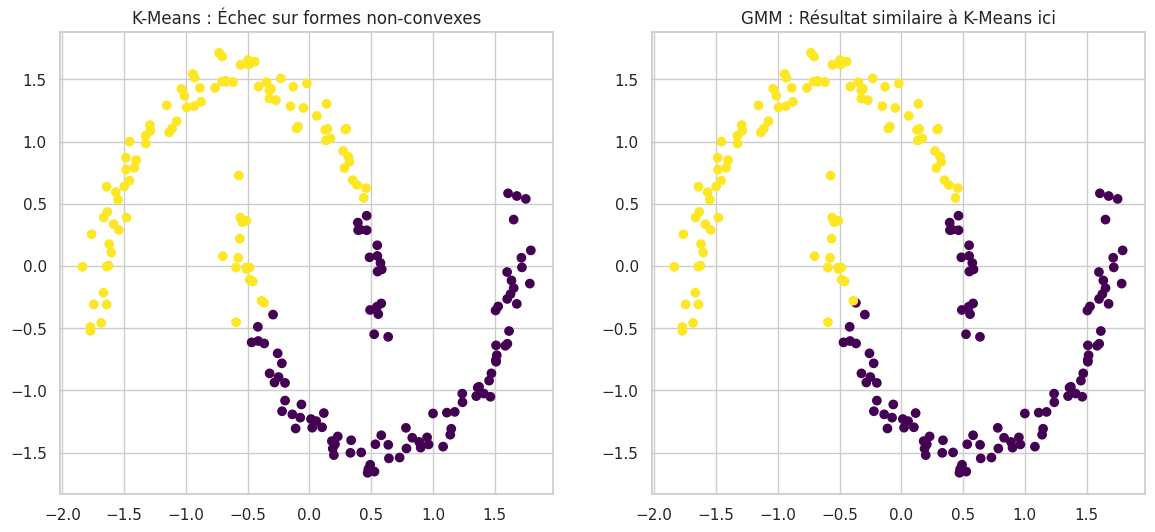

In [10]:
# Tâche 2.1: Comparaison K-Means vs GMM sur des données non-globulaires (Lunes) 
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_moons

# Génération des données "Moons"
X_moons, y_moons = make_moons(n_samples=200, noise=0.05, random_state=42)
X_moons_scaled = StandardScaler().fit_transform(X_moons)

# Modèle 1: K-Means
kmeans_moons = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans = kmeans_moons.fit_predict(X_moons_scaled)

# Modèle 2: GMM
gmm = GaussianMixture(n_components=2, random_state=42)
labels_gmm = gmm.fit_predict(X_moons_scaled)

# Visualisation comparative [cite: 363-364]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot K-Means
axes[0].scatter(X_moons_scaled[:, 0], X_moons_scaled[:, 1], c=labels_kmeans, cmap='viridis')
axes[0].set_title("K-Means : Échec sur formes non-convexes")

# Plot GMM
axes[1].scatter(X_moons_scaled[:, 0], X_moons_scaled[:, 1], c=labels_gmm, cmap='viridis')
axes[1].set_title("GMM : Résultat similaire à K-Means ici")

plt.show()

Note : Sur des "moons", GMM échoue souvent comme K-Means car il cherche tout de même des formes convexes (ellipses), alors que les lunes sont concaves.

### Density-Based Clustering (DBSCAN)

Tâche 2.2 : Fonctionnement de DBSCAN  DBSCAN regroupe les points situés dans des zones de forte densité et marque les points isolés comme du bruit.

$\epsilon$ (eps) : Rayon de voisinage autour d'un point.

minPts (min_samples) : Nombre minimum de points dans ce rayon pour former une "zone dense".

DBSCAN : Nombre de clusters trouvés : 2
Nombre de points de bruit : 1


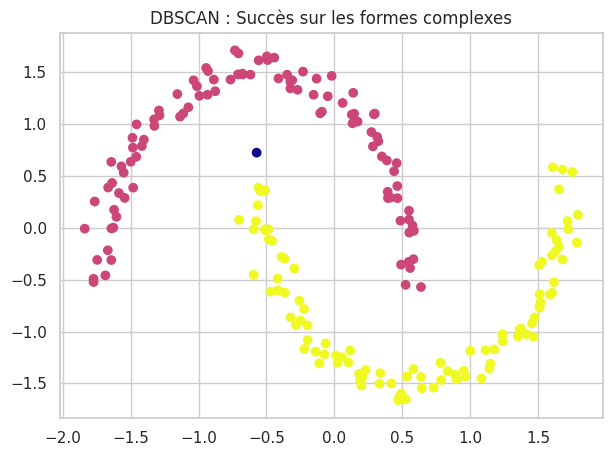

In [11]:
# Tâche 2.2: Application de DBSCAN 
from sklearn.cluster import DBSCAN

# Choix des hyperparamètres (Eps doit être ajusté selon la standardisation)
# Sur des données standardisées, eps=0.3 est souvent un bon point de départ.
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_moons_scaled)

# Analyse des résultats
num_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
num_noise = list(labels_dbscan).count(-1)

print(f"DBSCAN : Nombre de clusters trouvés : {num_clusters}")
print(f"Nombre de points de bruit : {num_noise}")

# Visualisation DBSCAN
plt.figure(figsize=(7, 5))
plt.scatter(X_moons_scaled[:, 0], X_moons_scaled[:, 1], c=labels_dbscan, cmap='plasma')
plt.title("DBSCAN : Succès sur les formes complexes")
plt.show()

### 2.3 Concepts de Voisinage et Similarité

#### Tâche 2.3 : Différence Supervisé/Non-Supervisé et Métriques 

L'apprentissage automatique (machine learning) se divise en plusieurs paradigmes, dont l'apprentissage supervisé et non supervisé, qui diffèrent fondamentalement par leurs objectifs, leurs données d'entrée et leurs applications.
Apprentissage supervisé (exemple : k-NN en classification ou régression)

Objectif principal : L'objectif est de prédire une sortie (label ou valeur) pour de nouvelles données en se basant sur un ensemble d'entraînement étiqueté. Il s'agit d'apprendre une fonction qui mappe les entrées (features) aux sorties connues, afin de minimiser les erreurs de prédiction.

Dans le cas du k-NN (k-Nearest Neighbors) en classification, l'algorithme vise à assigner une classe à un point de données en regardant les k voisins les plus proches dans l'espace des features (par exemple, voter pour la classe majoritaire parmi ces voisins). Cela permet de classer des données comme "spam" ou "non-spam" dans un e-mail.

En régression, k-NN prédit une valeur continue (par exemple, la moyenne des valeurs des k voisins), comme estimer le prix d'une maison en fonction de ses caractéristiques.

Caractéristiques : Le kNN nécessite des données labellisées (supervision humaine). L'évaluation se fait via des métriques comme l'accuracy (précision) pour la classification ou le MSE (Mean Squared Error) pour la régression. L'accent est mis sur la généralisation à des données invisibles.

Apprentissage non supervisé (exemple : Clustering)

Objectif principal : L'objectif est de découvrir des structures cachées ou des patterns dans les données sans labels prédéfinis. Il s'agit de grouper les données similaires ensemble ou de réduire la dimensionnalité, pour explorer et comprendre les données intrinsèquement.

Dans le clustering (par exemple, K-Means ou DBSCAN), l'algorithme regroupe les points de données en clusters basés sur leur similarité, sans savoir à l'avance ce que représentent ces groupes. Par exemple, segmenter des clients en groupes homogènes pour du marketing ciblé.

Caractéristiques : Il travaille sur des données non labellisées. L'évaluation est plus subjective, via des métriques comme le coefficient de silhouette ou l'inertie (Within-Cluster Sum of Squares). L'accent est mis sur l'exploration et la découverte, plutôt que sur la prédiction.

Différences clés

Supervision : Supervisé utilise des labels pour guider l'apprentissage (apprendre "quoi prédire"), tandis que non supervisé explore sans guidance (apprendre "comment structurer").
Sortie : Supervisé produit des prédictions (classes ou valeurs), non supervisé génère des insights (groupes, patterns).

Applications : Supervisé pour des tâches prédictives (e.g., diagnostic médical avec k-NN), non supervisé pour de l'analyse exploratoire (e.g., détection d'anomalies via clustering).
Risques : Supervisé peut sur-apprendre (overfitting) si les labels sont biaisés ; non supervisé peut produire des clusters arbitraires si les données sont bruyantes.

En résumé, l'apprentissage supervisé vise la prédiction guidée, tandis que le non supervisé vise la découverte autonome.

Métriques de similarité (hors Euclidienne) :

Cosinus : Pour le texte (NLP), mesure l'angle entre deux vecteurs (indépendant de la longueur du document).

Jaccard : Pour les ensembles, mesure l'intersection sur l'union (ex: similarité entre deux paniers d'achat).

Manhattan : Somme des différences absolues (utile en haute dimension).

#### Tâche 2.4 Optimisation de la Recherche : Explication de l'utilisation des KD-Trees et du Locality-Sensitive Hashing (LSH) pour réduire la complexité temporelle de la recherche des plus proches voisins dans de grandes bases de données

La recherche des plus proches voisins (Nearest Neighbor Search, ou NN search) est un problème fondamental en machine learning et en bases de données, consistant à trouver les points les plus similaires à un point de requête dans un espace multidimensionnel. Dans une approche naïve (brute force), on compare la requête à tous les points de la base (complexité O(n), où n est le nombre de points), ce qui devient prohibitif pour de grandes bases de données (e.g., millions de documents). Pour optimiser cela, des structures comme les KD-Trees et le Locality-Sensitive Hashing (LSH) sont utilisées, en réduisant le nombre de comparaisons nécessaires tout en maintenant une bonne approximation ou exactitude. Ces méthodes sont particulièrement utiles dans des systèmes de recommandation basés sur des documents, où les documents sont vectorisés (e.g., via TF-IDF ou embeddings) et la similarité est mesurée par des distances comme l'euclidienne ou le cosinus.

Les KD-Trees sont des arbres binaires de recherche généralisés pour des espaces k-dimensionnels, conçus pour partitionner efficacement les données et accélérer les recherches exactes ou approximatives de voisins.

Le LSH est une technique probabiliste pour des recherches approximatives de voisins dans des espaces de haute dimension, en utilisant des fonctions de hachage qui préservent la localité (points similaires ont une haute probabilité de tomber dans le même "bucket").

## PHASE 3 : MLOPS ET GESTION DU CYCLE DE VIE

### 3.1 Tracking avec MLflow

Nous allons loguer l'expérimentation K-Means pour garder une trace de la performance selon K .

In [12]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import calinski_harabasz_score

# Configuration MLflow 
mlflow.set_experiment("TP3_Clustering_Analysis")

def track_clustering_run(X_data, k, run_name):
    with mlflow.start_run(run_name=run_name):
        # Modèle
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_data)
        
        # Métriques 
        inertia_value = kmeans.inertia_
        score_silhouette = silhouette_score(X_data, labels)
        
        # 1. Logging Hyperparamètres 
        mlflow.log_param("K", k)
        mlflow.log_param("Algorithm", "KMeans")
        
        # 2. Logging Métriques 
        mlflow.log_metric("Inertia", inertia_value)
        mlflow.log_metric("Silhouette_Score", score_silhouette)
        
        # 3. Logging Modèle (Artifact) 
        mlflow.sklearn.log_model(kmeans, "kmeans_model")
        
        print(f"Run '{run_name}' logué : K={k}, Silhouette={score_silhouette:.4f}")

# Exécution du tracking pour différentes valeurs de K 
for k in [3, 4, 5]:
    track_clustering_run(X_scaled, k, f"KMeans_K{k}")

2026/01/18 21:21:23 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/01/18 21:21:23 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/01/18 21:21:23 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/01/18 21:21:23 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/01/18 21:21:23 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/01/18 21:21:23 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/01/18 21:21:23 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/18 21:21:23 INFO mlflow.store.db.utils: Updating database tables
2026/01/18 21:21:23 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/18 21:21:23 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/18 21:21:24 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/18 21:21:24 INFO alembic.runtime

Run 'KMeans_K3' logué : K=3, Silhouette=0.6018


2026/01/18 21:21:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Run 'KMeans_K4' logué : K=4, Silhouette=0.6888
Run 'KMeans_K5' logué : K=5, Silhouette=0.7213


### 3.2 Déploiement 

#### Tâche 3.2 

Une fois le K optimal choisi, le modèle K-Means et le StandardScaler (fitté sur les données d'entraînement) sont sérialisés avec joblib pour une sauvegarde efficace et rapide (e.g., joblib.dump(scaler, 'standard_scaler.joblib') et joblib.dump(kmeans, 'kmeans_model.joblib')).
Ces fichiers .joblib sont ensuite intégrés dans une API web (comme FastAPI) qui charge les modèles au démarrage et expose un endpoint /predict pour clusteriser de nouvelles données en appliquant d'abord le scaler puis le modèle.
L'ensemble est conteneurisé avec Docker via un Dockerfile simple (basé sur Python, installant les dépendances et copiant les modèles), permettant un déploiement scalable et portable sur cloud ou serveur.
En production, ce package transforme le clustering en outil opérationnel pour le département marketing, en permettant une segmentation client en temps réel via des requêtes API depuis un CRM.
Cela facilite des campagnes ciblées, des insights data-driven et une personnalisation des interactions, avec une scalabilité pour gérer des milliers de requêtes par jour.

#### Tâche 3.3 : Monitoring Post-Production

Centroid Drift (Dérive des centroïdes) : Si les centres des clusters bougent significativement au fil du temps, cela signifie que les profils types de clients changent (ex: inflation changeant la perception des prix).

Cluster Size Distribution : Si un cluster disparaît ou devient énorme (ex: tout le monde devient "Low Spenders"), le modèle est obsolète et doit être réentraîné.

## PHASE 4 : ADVANCED THEORETICAL CONCEPTS (EM, LDA)

Tâche 4.1 

Les algorithmes de clustering comme K-Means et GMM reposent sur l’optimisation de fonctions non convexes, ce qui entraîne l’existence de plusieurs minima locaux. Ainsi, le résultat final dépend fortement de l’initialisation des paramètres. Une initialisation aléatoire est simple mais peut produire des solutions instables et de faible qualité. Elle nécessite souvent plusieurs redémarrages pour espérer obtenir un bon minimum. La méthode K-Means++ propose une initialisation plus intelligente en sélectionnant des centroïdes bien espacés. Cette approche réduit le risque de convergence vers un minimum local défavorable. Elle permet également une convergence plus rapide de l’algorithme. Les résultats obtenus sont plus stables et reproductibles. Dans le cas des GMM, une mauvaise initialisation peut conduire à des composantes dégénérées. Pour cette raison, les GMM sont souvent initialisés à partir d’un K-Means bien configuré.

Tâche 4.2

La Latent Dirichlet Allocation (LDA) est un modèle probabiliste utilisé pour le topic modeling dans les collections de documents. Son objectif est d’identifier des thèmes latents à partir des cooccurrences de mots. LDA suppose qu’un document peut traiter de plusieurs thèmes simultanément. Chaque document est ainsi représenté par une distribution de probabilités sur les topics. De même, chaque topic est défini comme une distribution de probabilités sur les mots. Cette approche est appelée mixed membership modeling. À l’inverse, K-Means appliqué aux vecteurs TF-IDF affecte chaque document à un seul cluster. Cette affectation dure est souvent inadaptée aux textes complexes et multidisciplinaires. LDA capture mieux la structure sémantique latente des documents. Elle fournit également des résultats plus interprétables pour l’analyse et la recommandation de contenus.